# Building the environment

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import Networks
import numpy as np
import gym
from gym.spaces import Discrete, Box, Dict
from gym.envs.registration import EnvSpec

import ray
from ray import tune
from ray.rllib.agents.dqn.dqn_policy_graph import *
from ray.rllib.agents.ppo.ppo_policy_graph import *
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.env import MultiAgentEnv
from ray.rllib.models.preprocessors import DictFlatteningPreprocessor, Preprocessor

from ray.tune import run_experiments
from ray.tune.registry import register_env

### Environment Below


In [2]:
gamma = 0

def reward_calculator(travel_time, marginal_cost, soc_fac):
    # ADD THE BREMIAN DIVERGENCE!!!
    rew_dict = {}
    total_travel_time = 0
    for p, tt in travel_time.items():
        total_travel_time += tt
    for agent in travel_time.keys():
        # rew_dict[agent] = - (travel_time[agent] + soc_fac * marginal_cost[agent])
        rew_dict[agent] = - total_travel_time
    return rew_dict

## Routing Environment 
class RoutingEnv(MultiAgentEnv):
    """
    Description:
        The cars start at the same origin point, Point A, and need to reach the same destination, Point Z. 
        Each car can reach Point Z via a variety of routing choices described in a given network, in which 
        each route introduces different travel times and congestion. 
        The goal is to minimize the average travel times amongst each of the cars.
    
    Observation: 
        ## FILL OUT WHEN DONE
        Num	Observation                 Min          Max
        0	Previous Route Choice        0      total_routes-1
        1	Route Travel Time            0           +Inf
        2	Comm Message               -Inf          +Inf
        
    Actions:
        ## FILL OUT WHEN DONE
        Num	Action                      Min          Max
        0	Future Path_Choice           0      total_routes-1
        1	Comm Message               -Inf          +Inf
            
    Reward:
        Reward for each car is determined by the following formula: 
        marginal_cost = d[t(x_e)]/d[x_e]
        Cost = route_travel_time + λ(marginal_cost)
        Reward = -Cost
        ***
        route_travel_time: Travel time of the route previously taken by the car
        marginal_cost: Cost that the car's route choice imposes on everyone else. 
                       The formula above captures the change in the travel flow 
                       with respect to the change in vehicle flow on a given road.
        λ: Weight Toward Social Good (between 0 and 1)
        
    
    Starting State:
        All observations are assigned -1 for path choice and travel times.
    
    Episode Termination:
        Cars keeps a consistent routing distribution.
        Episode length is greater than 200
        Solved Requirements
        Considered solved when the average travel time is less than or equal to the theorical social optimum. 
    """
    
    def __init__(self, config):
        """
        FILL IN HERE.
        """
        self.network_name = config['network']
        self.num_paths = config['num_paths']
        self.soc_fac = config['soc_fac']
        self.num_veh = config['num_veh']
        self.num_obs = 2
        self.num_actions = 1
        self.state = None
        # Make observation space
        obs_spaces = {
            'prev_route': Discrete(self.num_paths),
            'prev_time': Box(low=0, 
                             high=float('+inf'), 
                             shape=(1,), 
                             dtype=np.float32)
        }
        self.preprocessor = DictFlatteningPreprocessor(Dict(obs_spaces))
        self.observation_space = self.preprocessor.observation_space
        # Make the action space
        self.action_space = Discrete(self.num_paths) # int between 0 and num_paths-1

    def get_state(self, **kwargs):
        return self.state
    
    def reset(self):
        """
        FILL IN HERE.
        """
        # Create initial observations for each vehicle
        start = {
            # Add something here
            'prev_route': 0,
            'prev_time': 0
        }
        self.state = {'car_{}'.format(i): self.preprocessor.transform(start) for i in range(self.num_veh)}
        return self.state
    
    def step(self, action_dict):
        ### ADD THE COMMUNICATION CHANNEL
        """
        FILL IN HERE.
        """
        obs_dict, rew_dict, done, info_dict = {}, {}, {}, {}
        
        # Apply the actions of every agent at the same time
        paths_flow_dict = {}
        
        for agent, rl_action in action_dict.items():
            # agent is one string that represent the id of the agent
            # rl_action is one number that represent the path choice of the agent,
            # rl_action should be a int between 0 and nb_paths-1
            rl_action = int(rl_action)
            assert type(rl_action) == int and rl_action > -1 and rl_action < network.nb_paths
            # we built a dictionnary paths_flow_dict that store the path flow on every path
            if rl_action in paths_flow_dict:
                paths_flow_dict[rl_action] += 1
            else:
                paths_flow_dict[rl_action] = 1

        # update the path travel times of the network given the path flows
        network.update_flow_from_dict(paths_flow_dict)
        
        
        # Calculate states, reward, and done for each agent
        travel_time = {}
        marginal_cost = {}
        
        for agent, path_choice in action_dict.items():
            path_choice = int(path_choice)
            assert type(path_choice) == int and path_choice > -1 and path_choice < network.nb_paths
            # network travel time ( path ) return the travel time of the path
            travel_time[agent] = network.travel_time(path_choice)
            # network marginal cost ( path ) return the marginal cost of the path
            marginal_cost[agent] = network.marginal_cost(path_choice)
            new_obs = {
                # Adding something here to change the observation space
                'prev_route': path_choice,
                'prev_time': travel_time[agent]
            }
            obs_dict[agent] = self.preprocessor.transform(new_obs)
            # Cost is the path_time
            # rew_dict[agent] = reward_calculator(agent, marginal_cost)
            # -path_choice # TO-DO: CHANGE THIS! 
            # Set done and infos
            done[agent] = True
            info_dict[agent] = {}
        rew_dict = reward_calculator(travel_time, marginal_cost, self.soc_fac)
        self.state = obs_dict   
        
        self.file = open("/Users/theophile/Documents/Classes/FLOW/Project/learning_wardrop/test_lambda_" + str(self.soc_fac) + "_gamma_" + str(gamma) + "_total_tt_2", 'a')
        self.file.write("Actions: " + str(action_dict) + '\n')
        self.file.write("Reward: " + str(rew_dict) + '\n')
        self.file.close()
        
        done["__all__"] = True
         
        return obs_dict, rew_dict, done, info_dict

### The following code runs the experiment for the multiagent problem.

Remark:
On the Braess network using 4 vehicles, we should get:
- if the social factor is 0, Nash: a reward of -3.75 in average, 2 cars on the first path, 1 on the second and third path
- if the social factor is 1, Social optimum: a travel time of -3.5 in average (a reward of ), 2 cars on the first path, 1 on the second and third path

In [3]:

# Setup policies for each vehicle

# to change
gamma = 0.5
lambd = 0

network_name = 'Braess'
nb_veh = 4
# network init should build the Network object
# ----- TO DO -----: import the network class
network = Networks.network(network_name, nb_veh)
# nb_path should be a property method

"""
define a function (class instantiation) which have for parameter a network name, 
and the number of vehicles, 
the return the num paths.

interface of the class network
class network:
    def __init__(self, network_name, nb_veh):
        load the network which correspond to the network_name
        define the nb_veh as the nb_veh
        from nb_veh and the intern demand define the number of flow that each veh represent
        also define __nb_paths to give it to the Env

    @property
    def nb_paths(self):
        return self.__nb_paths
"""

nb_path = network.nb_paths

env_config = {
    'network': network_name,
    'num_veh': nb_veh,
    'num_paths': nb_path,
    'soc_fac': lambd
}
routing_env = RoutingEnv(env_config)
car_obs_space = routing_env.observation_space
car_act_space = routing_env.action_space
config = {"gamma": gamma}
policy_graphs = {
    'vehicles': (DQNPolicyGraph, car_obs_space, car_act_space, config)
}

if __name__ == "__main__":
    print("Begin")
    env_creator_name = 'multi_routing'
    register_env(env_creator_name, lambda config: RoutingEnv(config))
    ray.init()
    experiments = {
        'route-DQN': {
            'run': 'DQN',
            'env': 'multi_routing',
            'stop': {
                'training_iteration': 100
            },
            'config': {
                'env_config': env_config,
                'multiagent': {
                    'policy_graphs': policy_graphs,
                    'policy_mapping_fn': tune.function(lambda agent_id: 'vehicles')
                }
            }
        },
        # put additional experiments to run concurrently here
    }
    print("End")
    
    run_experiments(experiments)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2018-12-04_15-54-23_2029/logs.
Waiting for redis server at 127.0.0.1:10494 to respond...


Begin


Waiting for redis server at 127.0.0.1:42692 to respond...
Starting the Plasma object store with 6.871947672999999 GB memory using /tmp.

View the web UI at http://localhost:8889/notebooks/ray_ui.ipynb?token=b35ab50e8fa9ac3743d90ef979ef1ddb30768ef1f9ed9aac

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.2/17.2 GB

Created LogSyncer for /Users/theophile/ray_results/route-DQN/DQN_multi_routing_0_2018-12-04_15-54-24em_8kgwo -> 
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.2/17.2 GB
Result logdir: /Users/theophile/ray_results/route-DQN
RUNNING trials:
 - DQN_multi_routing_0:	RUNNING



End


Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-54-37
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -56.0
  episode_reward_mean: -60.054
  episode_reward_min: -68.0
  episodes_this_iter: 1000
  episodes_total: 1000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: .nan
    max_exploration: 1.0
    min_exploration: 1.0
    num_steps_sampled: 1000
    num_steps_trained: 0
    num_target_updates: 1
    opt_peak_throughput: 0.0
    opt_samples: .nan
    replay_time_ms: .nan
    sample_time_ms: 10.488
    update_time_ms: 0.001
  iterations_since_restore: 1
  node_ip: 128.32.46.247
  num_metric_batches_dropped: 0
  pid: 2047
  policy_reward_mean:
    vehicles: -15.0135
  time_since_restore: 2.746082067489624
  time_this_iter_s: 2.746082067489624
  time_total_s: 2.746082067489624
  timestamp: 1543967677
  timesteps_since_restore: 1000
  timesteps_this_iter: 1000
  timesteps_total: 1000
  training_itera

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.9/17.2 GB
Result logdir: /Users/theophile/ray_results/route-DQN
RUNNING trials:
 - DQN_multi_routing_0:	RUNNING [pid=2047], 33 s, 7 iter, 7000 ts, -60.9 rew

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-55-13
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -56.0
  episode_reward_mean: -61.394
  episode_reward_min: -68.0
  episodes_this_iter: 1000
  episodes_total: 8000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 7.106
    max_exploration: 0.31400000000000006
    min_exploration: 0.31400000000000006
    num_steps_sampled: 8000
    num_steps_trained: 56000
    num_target_updates: 15
    opt_peak_throughput: 4503.361
    opt_samples: 32.0
    replay_time_ms: 3.05
    sample_time_ms: 10.588
    update_time_ms: 0.001
  iterations_since_restore: 8
  node_ip: 128.32.46.247
  num_met

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-55-44
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -58.0
  episode_reward_mean: -63.844
  episode_reward_min: -68.0
  episodes_this_iter: 1000
  episodes_total: 14000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.44
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 14000
    num_steps_trained: 104000
    num_target_updates: 27
    opt_peak_throughput: 4969.205
    opt_samples: 32.0
    replay_time_ms: 3.085
    sample_time_ms: 10.437
    update_time_ms: 0.001
  iterations_since_restore: 14
  node_ip: 128.32.46.247
  num_metric_batches_dropped: 0
  pid: 2047
  policy_reward_mean:
    vehicles: -15.961
  time_since_restore: 69.75951385498047
  time_this_iter_s: 5.06123685836792
  time_total_s: 69.75951385498047
  timestamp: 1543967744
  timesteps_since_restore: 14000
  timesteps_this_ite

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.9/17.2 GB
Result logdir: /Users/theophile/ray_results/route-DQN
RUNNING trials:
 - DQN_multi_routing_0:	RUNNING [pid=2047], 100 s, 20 iter, 20000 ts, -63.8 rew

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-56-20
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -58.0
  episode_reward_mean: -63.81
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 21000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.584
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 21000
    num_steps_trained: 160000
    num_target_updates: 41
    opt_peak_throughput: 4860.196
    opt_samples: 32.0
    replay_time_ms: 2.999
    sample_time_ms: 10.76
    update_time_ms: 0.001
  iterations_since_restore: 21
  node_ip: 128.32.46.247
 

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-56-52
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -58.0
  episode_reward_mean: -63.806
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 27000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 7.433
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 27000
    num_steps_trained: 208000
    num_target_updates: 53
    opt_peak_throughput: 4305.148
    opt_samples: 32.0
    replay_time_ms: 3.623
    sample_time_ms: 13.063
    update_time_ms: 0.001
  iterations_since_restore: 27
  node_ip: 128.32.46.247
  num_metric_batches_dropped: 0
  pid: 2047
  policy_reward_mean:
    vehicles: -15.9515
  time_since_restore: 137.62839102745056
  time_this_iter_s: 5.353967666625977
  time_total_s: 137.62839102745056
  timestamp: 1543967812
  timesteps_since_restore: 27000
  timesteps_thi

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.9/17.2 GB
Result logdir: /Users/theophile/ray_results/route-DQN
RUNNING trials:
 - DQN_multi_routing_0:	RUNNING [pid=2047], 169 s, 33 iter, 33000 ts, -63.8 rew

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-57-29
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -56.0
  episode_reward_mean: -63.806
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 34000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 7.026
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 34000
    num_steps_trained: 264000
    num_target_updates: 67
    opt_peak_throughput: 4554.246
    opt_samples: 32.0
    replay_time_ms: 3.047
    sample_time_ms: 10.734
    update_time_ms: 0.001
  iterations_since_restore: 34
  node_ip: 128.32.46.247

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-58-00
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -58.0
  episode_reward_mean: -63.782
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 40000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.878
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 40000
    num_steps_trained: 312000
    num_target_updates: 79
    opt_peak_throughput: 4652.196
    opt_samples: 32.0
    replay_time_ms: 3.003
    sample_time_ms: 10.96
    update_time_ms: 0.001
  iterations_since_restore: 40
  node_ip: 128.32.46.247
  num_metric_batches_dropped: 0
  pid: 2047
  policy_reward_mean:
    vehicles: -15.9455
  time_since_restore: 205.0972409248352
  time_this_iter_s: 5.1658899784088135
  time_total_s: 205.0972409248352
  timestamp: 1543967880
  timesteps_since_restore: 40000
  timesteps_this_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.9/17.2 GB
Result logdir: /Users/theophile/ray_results/route-DQN
RUNNING trials:
 - DQN_multi_routing_0:	RUNNING [pid=2047], 235 s, 46 iter, 46000 ts, -63.8 rew

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-58-36
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -56.0
  episode_reward_mean: -63.77
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 47000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.852
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 47000
    num_steps_trained: 368000
    num_target_updates: 93
    opt_peak_throughput: 4670.343
    opt_samples: 32.0
    replay_time_ms: 3.068
    sample_time_ms: 10.71
    update_time_ms: 0.001
  iterations_since_restore: 47
  node_ip: 128.32.46.247
 

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-59-07
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -56.0
  episode_reward_mean: -63.794
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 53000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 7.341
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 53000
    num_steps_trained: 416000
    num_target_updates: 105
    opt_peak_throughput: 4358.836
    opt_samples: 32.0
    replay_time_ms: 3.416
    sample_time_ms: 12.763
    update_time_ms: 0.001
  iterations_since_restore: 53
  node_ip: 128.32.46.247
  num_metric_batches_dropped: 0
  pid: 2047
  policy_reward_mean:
    vehicles: -15.9485
  time_since_restore: 272.7946147918701
  time_this_iter_s: 5.226161003112793
  time_total_s: 272.7946147918701
  timestamp: 1543967947
  timesteps_since_restore: 53000
  timesteps_this

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.9/17.2 GB
Result logdir: /Users/theophile/ray_results/route-DQN
RUNNING trials:
 - DQN_multi_routing_0:	RUNNING [pid=2047], 304 s, 59 iter, 59000 ts, -63.8 rew

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_15-59-44
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -58.0
  episode_reward_mean: -63.756
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 60000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.981
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 60000
    num_steps_trained: 472000
    num_target_updates: 119
    opt_peak_throughput: 4583.735
    opt_samples: 32.0
    replay_time_ms: 3.065
    sample_time_ms: 10.558
    update_time_ms: 0.001
  iterations_since_restore: 60
  node_ip: 128.32.46.24

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_16-00-15
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -56.0
  episode_reward_mean: -63.784
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 66000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.655
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 66000
    num_steps_trained: 520000
    num_target_updates: 130
    opt_peak_throughput: 4808.706
    opt_samples: 32.0
    replay_time_ms: 2.922
    sample_time_ms: 10.441
    update_time_ms: 0.001
  iterations_since_restore: 66
  node_ip: 128.32.46.247
  num_metric_batches_dropped: 0
  pid: 2047
  policy_reward_mean:
    vehicles: -15.946
  time_since_restore: 340.64011883735657
  time_this_iter_s: 5.118983030319214
  time_total_s: 340.64011883735657
  timestamp: 1543968015
  timesteps_since_restore: 66000
  timesteps_thi

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.9/17.2 GB
Result logdir: /Users/theophile/ray_results/route-DQN
RUNNING trials:
 - DQN_multi_routing_0:	RUNNING [pid=2047], 371 s, 72 iter, 72000 ts, -64.1 rew

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_16-00-51
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -58.0
  episode_reward_mean: -63.81
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 73000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.484
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 73000
    num_steps_trained: 576000
    num_target_updates: 144
    opt_peak_throughput: 4935.237
    opt_samples: 32.0
    replay_time_ms: 3.285
    sample_time_ms: 10.536
    update_time_ms: 0.001
  iterations_since_restore: 73
  node_ip: 128.32.46.247

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_16-01-23
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -58.0
  episode_reward_mean: -63.802
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 79000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.499
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 79000
    num_steps_trained: 624000
    num_target_updates: 156
    opt_peak_throughput: 4923.596
    opt_samples: 32.0
    replay_time_ms: 2.978
    sample_time_ms: 10.379
    update_time_ms: 0.001
  iterations_since_restore: 79
  node_ip: 128.32.46.247
  num_metric_batches_dropped: 0
  pid: 2047
  policy_reward_mean:
    vehicles: -15.9505
  time_since_restore: 408.04302620887756
  time_this_iter_s: 5.073289155960083
  time_total_s: 408.04302620887756
  timestamp: 1543968083
  timesteps_since_restore: 79000
  timesteps_th

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.9/17.2 GB
Result logdir: /Users/theophile/ray_results/route-DQN
RUNNING trials:
 - DQN_multi_routing_0:	RUNNING [pid=2047], 438 s, 85 iter, 85000 ts, -63.9 rew

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_16-01-59
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -56.0
  episode_reward_mean: -63.734
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 86000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.902
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 86000
    num_steps_trained: 680000
    num_target_updates: 170
    opt_peak_throughput: 4636.239
    opt_samples: 32.0
    replay_time_ms: 3.026
    sample_time_ms: 10.684
    update_time_ms: 0.001
  iterations_since_restore: 86
  node_ip: 128.32.46.24

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_16-02-31
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -58.0
  episode_reward_mean: -63.768
  episode_reward_min: -64.0
  episodes_this_iter: 1000
  episodes_total: 92000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.641
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 92000
    num_steps_trained: 728000
    num_target_updates: 182
    opt_peak_throughput: 4818.824
    opt_samples: 32.0
    replay_time_ms: 2.917
    sample_time_ms: 11.353
    update_time_ms: 0.001
  iterations_since_restore: 92
  node_ip: 128.32.46.247
  num_metric_batches_dropped: 0
  pid: 2047
  policy_reward_mean:
    vehicles: -15.942
  time_since_restore: 475.3290812969208
  time_this_iter_s: 5.075453758239746
  time_total_s: 475.3290812969208
  timestamp: 1543968151
  timesteps_since_restore: 92000
  timesteps_this_

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 1/8 CPUs, 0/0 GPUs
Memory usage on this node: 9.9/17.2 GB
Result logdir: /Users/theophile/ray_results/route-DQN
RUNNING trials:
 - DQN_multi_routing_0:	RUNNING [pid=2047], 505 s, 98 iter, 98000 ts, -63.8 rew

Result for DQN_multi_routing_0:
  custom_metrics: {}
  date: 2018-12-04_16-03-06
  done: false
  episode_len_mean: 1.0
  episode_reward_max: -58.0
  episode_reward_mean: -63.97
  episode_reward_min: -68.0
  episodes_this_iter: 1000
  episodes_total: 99000
  experiment_id: d668af2553d94ba8b5d228d477f82773
  hostname: C02X23AUJHD3
  info:
    grad_time_ms: 6.754
    max_exploration: 0.020000000000000018
    min_exploration: 0.020000000000000018
    num_steps_sampled: 99000
    num_steps_trained: 784000
    num_target_updates: 196
    opt_peak_throughput: 4738.005
    opt_samples: 32.0
    replay_time_ms: 3.025
    sample_time_ms: 10.585
    update_time_ms: 0.001
  iterations_since_restore: 99
  node_ip: 128.32.46.247

## Plotting the results

### First, we use the travel time of the last iteration as the reward
$\gamma = 0$ and $\lambda = 0$.
We should obtain the nash equilibrium:
Where the travel time are $[3.75, 3.75, 3.75]$

### Then, we use marginal cost of the last iteration as the reward
$\gamma = 0$ and $\lambda = 1$.
We should obtain the social equilibrium:
Where the travel time are $[3.25, 3.5, 3.5]$

This is not the case here. It seems that the cars learn to do all the same thing.

### We should try to add the bregman divergence in the reward (cf Walid, with a $\gamma = 1$ (no regret online learning).
### We should try to understand the learning process of the agents
### We should also try to change the discount factor $\gamma$
### We should also add the communication process

In [4]:
def get_tt_mc(action_dict, network, soc_fact):
    paths_flow_dict = {}
    for agent, rl_action in action_dict.items():
        rl_action = int(rl_action)
        if rl_action in paths_flow_dict:
            paths_flow_dict[rl_action] += 1
        else:
            paths_flow_dict[rl_action] = 1
    network.update_flow_from_dict(paths_flow_dict)

    travel_time = {}
    marginal_cost = {}
    for agent, path_choice in action_dict.items():
        path_choice = int(path_choice)
        travel_time[agent] = network.travel_time(path_choice)
        marginal_cost[agent] = network.marginal_cost(path_choice)
    rew_dict = reward_calculator(travel_time, marginal_cost, soc_fact)
    return travel_time, marginal_cost, rew_dict

In [8]:
import ast

file = open("/Users/theophile/Documents/Classes/FLOW/Project/learning_wardrop/test_lambda_0_gamma_0.5_total_tt_2", 'r')
j = 0
# we want to plot the evolution of the path choice, of the reward and of the travel time
Actions_plot = np.array([[0, 0, 0, 0]])
Reward_plot = np.array([[0, 0, 0, 0]])
Travel_time_plot = np.array([[0, 0, 0, 0]])
while(True):
    j = j+1
    try:
        actions = file.readline()
        rewards = file.readline()
        action_dict = ast.literal_eval("{" + actions.split('{')[1].split('}')[0]+ "}")
        reward_dict = ast.literal_eval("{" + rewards.split('{')[1].split('}')[0]+ "}")
    
        network = Networks.network(network_name, nb_veh)
        travel_time, marginal_cost, rew_dict = get_tt_mc(action_dict, network, 0)
        
        actions_np = np.fromiter(action_dict.values(), dtype=int)
        Actions_plot = np.append(Actions_plot, [actions_np], axis=0)
        rewards_np = np.fromiter(reward_dict.values(), dtype=float)
        Reward_plot = np.append(Reward_plot, [rewards_np], axis=0)
        travel_time_np = np.fromiter(travel_time.values(), dtype=float)
        Travel_time_plot = np.append(Travel_time_plot, [travel_time_np], axis=0)
        if(j==1):
            print("------ First iteration ------")
            print("Path choice: " + str(action_dict))
            print("Reward ray: " + str(reward_dict))
            print("Travel time paths: " + str({"path " + str(i): network.travel_time(i) for i in range(3)}))
            print("Travel time cars: " + str(travel_time))
            print("Marginal cost: " + str(marginal_cost))
            print("Reward network: " + str(rew_dict))
    except:
        print()
        print("------ Last iteration ------")
        print("Path choice: " + str(action_dict))
        print("Reward ray: " + str(reward_dict))
        print("Travel time paths: " + str({"path " + str(i): network.travel_time(i) for i in range(3)}))
        print("Travel time cars: " + str(travel_time))
        print("Marginal cost: " + str(marginal_cost))
        print("Reward network: " + str(rew_dict))
        break


------ First iteration ------
Path choice: {'car_0': 1, 'car_1': 1, 'car_2': 1, 'car_3': 0}
Reward ray: {'car_0': -15.5, 'car_1': -15.5, 'car_2': -15.5, 'car_3': -15.5}
Travel time paths: {'path 0': 3.5, 'path 1': 4.0, 'path 2': 3.25}
Travel time cars: {'car_0': 4.0, 'car_1': 4.0, 'car_2': 4.0, 'car_3': 3.5}
Marginal cost: {'car_0': 1.0, 'car_1': 1.0, 'car_2': 1.0, 'car_3': 1.25}
Reward network: {'car_0': -15.5, 'car_1': -15.5, 'car_2': -15.5, 'car_3': -15.5}

------ Last iteration ------
Path choice: {'car_0': 2, 'car_1': 2, 'car_2': 2, 'car_3': 2}
Reward ray: {'car_0': -16.0, 'car_1': -16.0, 'car_2': -16.0, 'car_3': -16.0}
Travel time paths: {'path 0': 3.25, 'path 1': 3.0, 'path 2': 4.0}
Travel time cars: {'car_0': 4.0, 'car_1': 4.0, 'car_2': 4.0, 'car_3': 4.0}
Marginal cost: {'car_0': 1.0, 'car_1': 1.0, 'car_2': 1.0, 'car_3': 1.0}
Reward network: {'car_0': -16.0, 'car_1': -16.0, 'car_2': -16.0, 'car_3': -16.0}


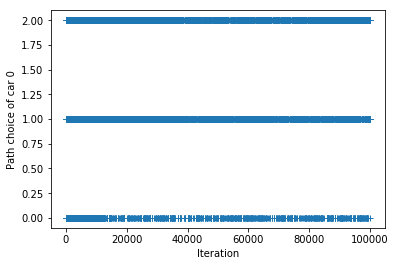

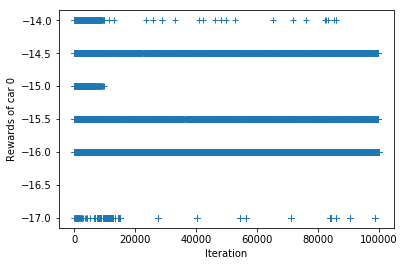

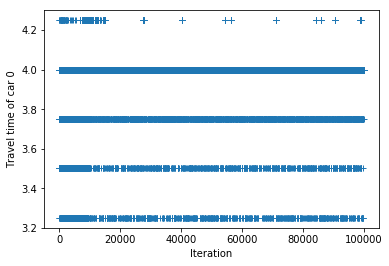

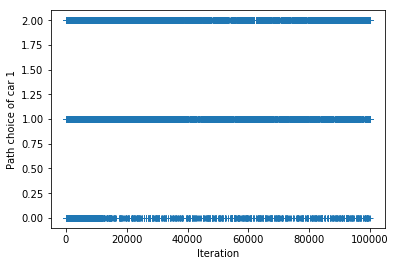

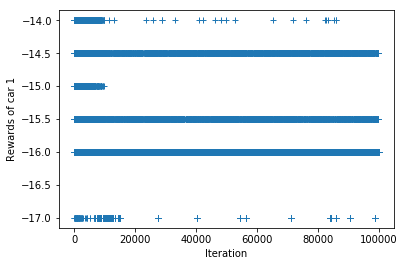

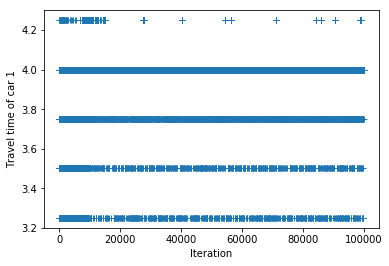

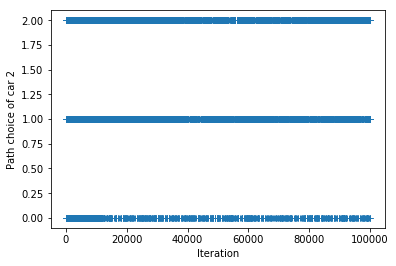

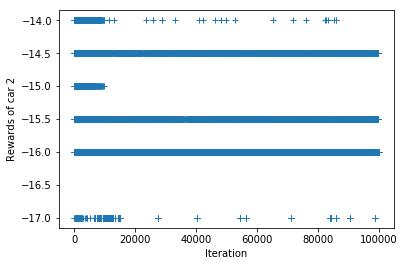

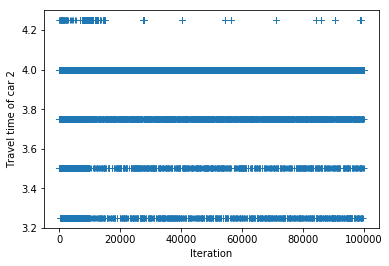

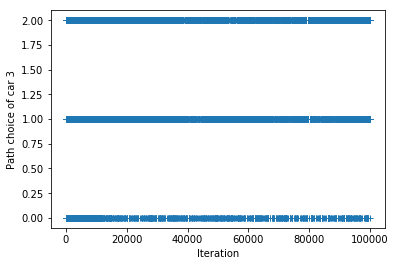

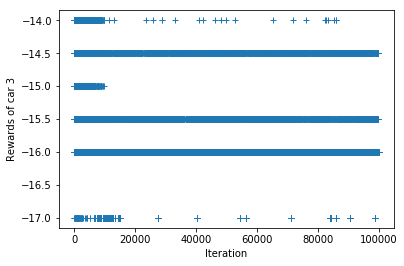

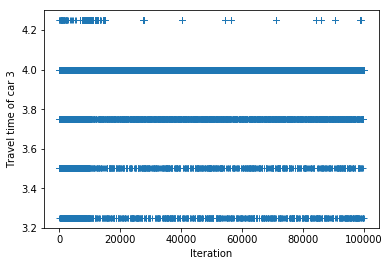

In [9]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.plot(Actions_plot[1:,i], "+")
    plt.ylabel("Path choice of car " + str(i))
    plt.xlabel("Iteration")
    plt.show()
    
    plt.plot(Reward_plot[1:,i], "+")
    plt.ylabel("Rewards of car " + str(i))
    plt.xlabel("Iteration")
    plt.show()
    
    plt.plot(Travel_time_plot[1:,i], "+")
    plt.ylabel("Travel time of car " + str(i))
    plt.xlabel("Iteration")
    plt.show()
